In [ ]:
import numpy as np
import pandas as pd
from sklearn import model_selection
# import liste des mots vides
from nltk.corpus import stopwords
# import fonction pour télécharger des ensemble de données
from nltk import download
import seaborn as sns
#Utiliser pour le traitement du langage naturel
import spacy
# Pour le rééquilibrage des classes
from imblearn.over_sampling import RandomOverSampler
import string
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding


In [ ]:

"""
Cette ligne charge le modèle de traitement du langage naturel pré-entraîné en
français.
Ce modèle contient des informations telles que des vecteurs de mots et
des règles de grammaire, qui sont utilisées pour analyser le texte en français.

"""
#utile pour télécharger les stopword
!python3 -m spacy download fr_core_news_sm
nlp=spacy.load('fr_core_news_sm')
download('stopwords')
stopWord=set(stopwords.words('french'))
print(stopWord)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 37.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
{'fus', 'eux', 'avec', 'êtes', 'était', 'seriez', 'vos', 'été', 'ce', 'aient', 'vous', 'ayantes', 'eussent', 'aurions', 'serons', 'sa', 'nous', 'eussiez', 'votre', 'serait', 'auraient', 'aura', 'sera', 'étais', 'étaient', 'as', 's', 'eurent', 'tu', 'ai', 'eu', 'étiez', 'ta', 'aux', 'ayons', 'et', 't', 'soyez', 'c', 'la', 'eus', 'il', 'étions', 'mes', 'ou', 'j', 'ayez', 'ma', 'étants', 'aviez', 'nos', 'serais', 'fussions', 'ils', 'tes', 'aurez', 'avions', 'avais', 'eussions', 'étés', 'étées', 'eût', 'ayante', 'serez', 'fussent', 'y', 'sommes', 'avaient', 'les', 'seraient', 'au

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importer les données

In [ ]:
#Importer jeu d'entrainement
data_train = pd.read_csv('donnees/train.tsv',sep='\t')
data_train.info()
train = data_train[['headline','text','category']]

#Importer jeu de test
data_test= pd.read_csv('donnees/test.tsv',sep='\t')
test = data_test[['headline','text','category']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1476 non-null   object
 1   headline  1476 non-null   object
 2   text      1476 non-null   object
 3   url       1476 non-null   object
dtypes: object(4)
memory usage: 46.2+ KB


# Pré-traitement des données

In [ ]:
def traitement_text(phrase):
    """
    Cette fonction prend en entrée une phrase et renvoie la phrase prétraitée.
    Args:
        phrase (str): La phrase à prétraiter.
    """
    #Tokenization: phrase diviser en mot
    doc = nlp(phrase)
    liste_doc=[] #stock les mots tokenisés
    result =[] #resultat final du mot
    for i in doc:
        #supprimer les mots vides et la ponctuation
        if i.text.lower() not in stopWord and (i.text not in string.punctuation):
            liste_doc.append(i)
    #Lemmatization: réduire les mots à leur forme de base
    for i in liste_doc:
        result.append(i.lemma_.lower())

    return " ".join(result)

On a pu voir dans l'analyse des données, qu'il y a un déséquilibre dans les catégories.

Il faut donc rééquilibrer les données pour que le modèle puisse apprendre correctement.


## Rééquilibrage des données

Tres long à executer

Le code suivant traite de la préparation des données d'entraînement pour un modèle de machine learning, avec des étapes de sélection, de prétraitement et de suréchantillonnage des données.

In [ ]:
X = train.drop('category', axis=1) #Possède les colonnes 'headline' et 'text'
y = train['category'] #Possède la colonne 'category'

#Suréchantillonnage aléatoire des données
random_values = RandomOverSampler(random_state=1)

#Application des prétraitements des données pour avoir juste des mots sans ponctuations ni stopword
X['headline'] = X['headline'].apply(traitement_text)
X['text'] = X['text'].apply(traitement_text)

#Surécantillonnage  - Rééquilibrer les classes
X_resampled, y_resampled = random_values.fit_resample(X, y)

# Conversion des données suréchantillonnées en DataFrame
train = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='category')], axis=1)


<Axes: xlabel='category'>

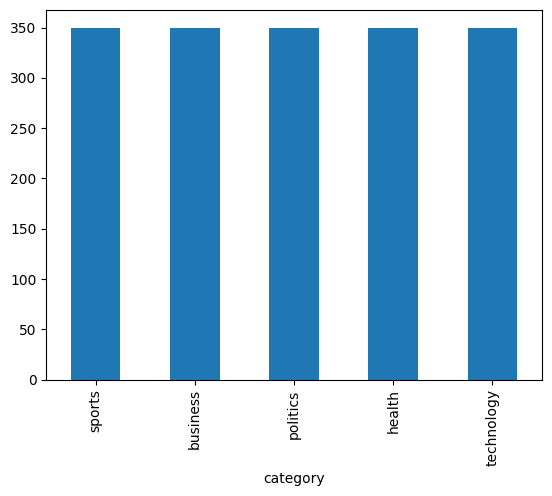

In [ ]:
train['category'].value_counts().plot(kind='bar')

## Indexer les valeurs de catégorie

### Fonction pour créer un dictionnaire qui mappe les catégories

In [ ]:
nom_categorie=sorted(train['category'].unique().flatten())
#flatten utile pour avoir un tableau à une seule dimension
"""
Fonction qui permet d'indexer la colonne catégorie
"""
def creer_index(train):
    index_categorie={
        nom_categorie[i]:i for i in range(len(nom_categorie))
    }

    return index_categorie

creer_index(train)


{'business': 0, 'health': 1, 'politics': 2, 'sports': 3, 'technology': 4}

### Remplacer les catégories par les index

In [ ]:
"""
Remplace les noms des catégories par les index associées aux catégories
"""

train=train.replace({'category':creer_index(train)})
train.head()
#data_train.head()

,headline,text,category
0,le ouganda le assaut fimbu rdc,le ouganda placer 79 classement fifa 4 avril 2...,3
1,stopper détérioration l’ environnement sauver ...,responsable biodiversité nation uni estime nég...,0
2,coupe de afrique nation 2022 sélectionneur sie...,sélectionneur sierra leone john keister affirm...,3
3,tissu africain pourquoi teinturerie historique...,depuis plus six siècle vaste zone situer ville...,0
4,revenu pendant pandémie dix homme plus riche p...,pendant pandémie coronavirus richesse combiner...,0


# Test

train[['headline','text]]: features à partir desquelles le modèle apprend

train[['category']]: target, modèle qu'on essaye de prédire

test_size: portion de l'ensemble de données (0.2= 20% données seront pour le test

random_stat: nombre aléatoire de mélange

shuffle: mélanger les données avant de diviser les données

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(train[['headline', 'text']],
                                                    train[['category']],
                                                    test_size=0.2,
                                                    random_state=12,
                                                    shuffle=True)


   X_train, y_train : Sous-ensembles d'entraînement contenant 80% des données. X_train inclut les colonnes headline et text, et y_train inclut la colonne category.
   
   X_val, y_val : Sous-ensembles de validation (test) contenant 20% des données. X_val inclut les mêmes colonnes que X_train, et y_val inclut la même colonne que y_train.

Pour vectoriser apres, on va tous simplement combiner le 'headline' et le 'text' pour avoir un seul texte.

In [ ]:
X_train= X_train.headline + ' ' + X_train.text
X_train.head()

1543    piratage informatique paiement rançon devoir i...
1621    logiciel de extorsion fonds pirater vidéo porn...
1358    boris johnson démissionner 5 chose conduire ch...
569     pétrole voler nigéria le armée homme nommé gov...
828     fait marquant sport 2020 covid 19 avoir vider ...
dtype: object

In [ ]:
y_train.head()

,category
1543,4
1621,4
1358,2
569,0
828,3


Permet d'afficher le nombre de ligne et de colonne de X_train et y_train (jeu d'entrainement)

X_train: le nombre de ligne vue qu'on a concaténé
y_train: nombre de ligne et la colonne category

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1400,)
(1400, 1)


## Indexation du vocabulaire

In [ ]:
"""
Focntion qui permet de transformer un texte en forme numérique
dans le but de préparer le texte à un NLP
"""
def get_vectorizer(documents, max_voc_size=8000, max_seq_length=50, batch_size=128):
  vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_voc_size,
                                 output_sequence_length=max_seq_length)
  # Création du jeu de données à partir de X_train et constitution de lots de 128 instances
  text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
  # Création du vocabulaire à partir des données d'entrée
  vectorizer.adapt(text_ds)
  return vectorizer

Juste TextVectorization ne fonctionne pas on a du ajouter le tf.keras.layers

La fonction prend en entrée une liste de mots et crée un vectoriseur de texte en utilisant TextVect...

Elle crée un jeu de donées à partir des mots.


TextVectorization est une couche de prétraitement de Keras qui convertit le texte en séquences d'indices entiers. Chaque entier représente un token dans un dictionnaire de taille max_voc_size.

## Vectorizer le jeu de test X_train

Permet de rendre X_train un vecteur pour rendre l'utilisation des NLP possible


In [ ]:
vectoriz=get_vectorizer(X_train)

Le vocabulaire obtenu est le suivant. Le vocabulaire est une liste de chaines de caractère, où chaque chaine represente un token

In [ ]:
vocabulaire=vectoriz.get_vocabulary()
print(len(vocabulaire))
vocabulaire[:5]

8000


['', '[UNK]', 'le', 'avoir', 'de']

In [ ]:
mot_index=dict(zip(vocabulaire, range(len(vocabulaire))))

Créer un dictionnaire qui associe chaque mot(token) à un indice unique.
C'est une étape typique dans le traitement du langage naturel lorsqu'on souhaite convertir du texte en une représentation numérique pour un traitement ultérieur, en particulier avec des modèles d'apprentissage automatique comme les réseaux de neurones.


## Plongements de mots pré-entrainés

J'ai récupéré le fichier du TP2_BILSTM, le modèle 26

In [ ]:
"""
Focntion qui permet de charger in fichier de vecteur et stocker
les vecteurs dans un dictionnaire
"""
def load_embeddings(embeddings_file):
  embeddings_index = {}
  with open(embeddings_file, 'r', encoding='utf8') as f:
      for line in f:
          word, coefs = line.split(maxsplit=1)
          coefs = np.fromstring(coefs, "f", sep=" ")
          embeddings_index[word] = coefs
  print(f'{len(embeddings_index)} vecteurs de mots ont été lus')
  return embeddings_index

Cette fonction prend en entrée le chemin du fichier de plongement de mot pré-entrainé. Elle va ouvrir le fichier en lecture et parcourt chaque ligne qui correspond à un mot et ses vecteurs.
elle va diviser chaque ligne en 2 pour avoir le mot et ses vecteurs.
La fonction convertit les vecteurs de chaîne de caractères en un tableau NumPy en utilisant np.fromstring(), puis stocke chaque mot et ses vecteurs dans le dictionnaire


In [ ]:
embeddings = load_embeddings('donnees/model_26.txt')

1836 vecteurs de mots ont été lus


In [ ]:
"""
Fonction qui permet de créer une matrice en alignant  un vocabulaire données
avec des vecteurs d'embeddings pré-entrainées
"""
def get_embedding_matrix(vocabulary, embeddings_index, embedding_dim = 300):
  num_tokens = len(vocabulary)
  hits = 0 #Compteur pour savoir combien de mots trouvés dans embeddings_index
  misses = 0 #Compteur pour savoir combien de mots non trouvés dans embeddings_index

  # Préparation de la matrice
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in mot_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
  print(f'{misses} sont absents')
  return embedding_matrix

Cette fonction crée une matrice d'embedding à partir d'un dictionnaire de vecteurs de mots pré-entraine et d'un vocabulaire donné.
Les mots présents dans le vocabulaire mais absents des embeddings pré-entraînés auront des vecteurs nuls.


In [ ]:
embedding_matrice = get_embedding_matrix(vocabulaire, embeddings)


449 mots ont été trouvés dans les plongements pré-entraînés
7551 sont absents


# Construction du LSTM et entraînement du LSTM

## Construction du LSTM

In [ ]:
"""
Fonction qui définit et renvoie un modèle de réseaux de neurones utilsant
une architecture LSTM pour la classification de texte
"""

def get_biLSTM_model(voc_size, embedding_matrix, embedding_dim=300):
  # Création du modèle
  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(voc_size, embedding_dim, trainable=True,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  )

  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedded_sequences)
  preds = layers.Dense(len(nom_categorie), activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  return model

Cette fonction crée un modèle de réseau de neuronnes récurrent bidirectionnel avec une couche pré-entrainé  pour la classification de texte.


Elle crée une couche d'entrée pour les séquences d'entiers de taille variable.
Elle crée une couche d'embedding en utilisant la classe Embedding de Keras. Les poids de cette couche sont initialisés avec la matrice d'embedding pré-entraînée fournie.
Elle crée une couche bidirectionnelle de type LSTM avec 64 unités et une régularisation de dropout.
Elle ajoute une couche dense avec une fonction d'activation softmax pour prédire la classe de sortie.
Elle crée et retourne le modèle Keras.

In [ ]:
taille_vocabulaire=len(vocabulaire)
biLSTM_model= get_biLSTM_model(taille_vocabulaire,embedding_matrice )
biLSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         2400000   
                                                                 
 bidirectional (Bidirection  (None, 128)               186880    
 al)                                                             
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 2587525 (9.87 MB)
Trainable params: 2587525 (9.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Entrainement du LSTM


In [ ]:
"""
Fonction pour l'entraînement d'un modèle en utilisant une validation croisée
"""
def train_model(X, y, model_function, vectorizer,
                voc_size, embedding_matrix, embedding_dim=300, batch_size=128):
  # Listes utilisées pour sauvegarder les résultats obtenus à chaque pli
  acc_per_fold = []
  loss_per_fold = []
  histories = []
  folds = 5
  stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True,
                                              random_state=12)
  fold_no = 1
  for train, test in stratkfold.split(X, y):
    m_function = globals()[model_function]
    model = m_function(voc_size, embedding_matrix, embedding_dim)

    print('------------------------------------------------------------------------')
    print(f'Entraînement pour le pli {fold_no} ...')
    fold_x_train = vectorizer(X.iloc[train].to_numpy()).numpy()
    fold_x_val = vectorizer(X.iloc[test].to_numpy()).numpy()
    fold_y_train = y.iloc[train].to_numpy()
    fold_y_val = y.iloc[test].to_numpy()

    # Compilation du modèle : permet de préciser la fonction de perte et l'optimiseur
    # loss=sparse_categorical_crossentropy : entropie croisée, dans le cas où les
    #  classes cibles sont indiquées sous forme d'entiers. Il s'agira de minimiser
    #  la perte pendant l'apprentissage
    # optimizer=rmsprop : l'optimiseur détermine la manière doit les poids seront
    #  mis à jour pendant l'apprentissage
    model.compile(
      loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
    )
    # Entraînement
    history = model.fit(fold_x_train, fold_y_train, batch_size=batch_size,
                        epochs=10, validation_data=(fold_x_val, fold_y_val))
    histories.append(history)
    # Evaluation sur les données de validation
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
          f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1

  # Affichage des scores moyens par pli
  print('---------------------------------------------------------------------')
  print('Scores par pli')
  for i in range(0, len(acc_per_fold)):
    print('---------------------------------------------------------------------')
    print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}',
          f'- Accuracy: {acc_per_fold[i]:.2f}%')
  print('---------------------------------------------------------------------')
  print('Scores moyens pour tous les plis :')
  print(f'> Accuracy: {np.mean(acc_per_fold):.2f}',
        f'(+- {np.std(acc_per_fold):.2f})')
  print(f'> Loss: {np.mean(loss_per_fold):.2f}')
  print('---------------------------------------------------------------------')
  return histories

In [40]:
biLSTM_histories = train_model(X_train, y_train, 'get_biLSTM_model',
                            vectoriz, taille_vocabulaire, embedding_matrice)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/10
9/9 [==============================] - 14s 830ms/step - loss: 1.6043 - acc: 0.2714 - val_loss: 1.5908 - val_acc: 0.3679
Epoch 2/10
9/9 [==============================] - 6s 619ms/step - loss: 1.5732 - acc: 0.4027 - val_loss: 1.5543 - val_acc: 0.5036
Epoch 3/10
9/9 [==============================] - 7s 718ms/step - loss: 1.4656 - acc: 0.5054 - val_loss: 1.1965 - val_acc: 0.5286
Epoch 4/10
9/9 [==============================] - 6s 623ms/step - loss: 0.9934 - acc: 0.6116 - val_loss: 0.9387 - val_acc: 0.6429
Epoch 5/10
9/9 [==============================] - 7s 791ms/step - loss: 0.5877 - acc: 0.8250 - val_loss: 0.6914 - val_acc: 0.7464
Epoch 6/10
9/9 [==============================] - 6s 619ms/step - loss: 0.3731 - acc: 0.8929 - val_loss: 0.6983 - val_acc: 0.7679
Epoch 7/10
9/9 [==============================] - 7s 800ms/step - loss: 0.2191 - acc: 0.9482 - val_loss: 0.9110 - v

Cette sortie détaille les résultats de l'entrainement et de l'évaluation de votre modèle BiLSTM sur ici 5 folds (plis).
Pour chaque pli, le modèle a été entraine pendant 10 epoques, on a l'évolution de perte (loss) et la précision (accuracy) pour les entraineemnts (acc) et validation (val_acc)

Perte(loss): indique l'erreur du modèle, où plus c'est bas mieux s'est
Precision(accurate): pourcentage de classification correcte

**Interprétation des résultats:** On a une précision moyenne de 75;57%, ce qui montrent que le modèle a une capacité raisonnable à classifier correctement les instances. L'ecart montre que le modèle est assez stable et n'est pas trop sensible aux variations.



Pour avoir les résultats sous forme de graphique

In [ ]:
def plot_results(histories):
  accuracy_data = []
  loss_data = []
  for i, h in enumerate(histories):
    acc = h.history['acc']
    val_acc = h.history['val_acc']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    for j in range(len(acc)):
      accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
      accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
      loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
      loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

  acc_df = pd.DataFrame(accuracy_data,
                        columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
  sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
              kind='line')

  loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
  sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
              kind='line')

In [ ]:
plot_results(biLSTM_histories)